In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

In [3]:
# Upload your file
from google.colab import files
uploaded = files.upload()

# Read the dataset
boston_df = spark.read.csv("BostonHousing.csv", header=True, inferSchema=True)
boston_df.show(5)

Saving BostonHousing.csv to BostonHousing.csv
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



# **Step 3:** Single Vector columns using VectorAssembler

In [4]:
from pyspark.ml import pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorAssembler

only_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
feat_df= assembler.transform(boston_df).select("features")
feat_df.show(6)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
|[0.02985,0.0,2.18...|
+--------------------+
only showing top 6 rows



# **Step 4** Standardize features for principal component

In [5]:
##
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(feat_df)
scaled_df = scalerModel.transform(feat_df)
scaled_df.show(6)



+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
+--------------------+--------------------+
only showing top 6 rows



# **Step 5** Train model for two principal component analysis

In [6]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(scaled_df)
result = model.transform(scaled_df)
result.show(6)

+--------------------+--------------------+--------------------+
|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [7]:
#collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme
import pandas as pd
from sklearn.decomposition import PCA

pca_features = result.rdd.map(lambda row: row.pcaFeatures).collect()
pca_features = np.array(pca_features)
pca_features

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [8]:
#Convert Array to Dataframe
pca_df = pd.DataFrame(pca_features, columns=['PC_first', 'PC_second'])
pca_df.head()

,PC_first,PC_second
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


# **Step 7**: Plot two principal components

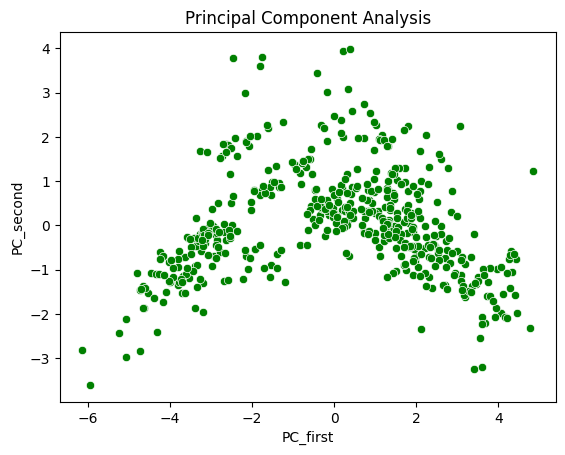

In [9]:
#
sns.scatterplot(x='PC_first', y='PC_second', data=pca_df, color='green')
plt.xlabel('PC_first')
plt.ylabel('PC_second' )
plt.title('Principal Component Analysis')
plt.show()

# **Step 8**: Vectorize features and target together for model development

In [10]:
#
#use the vectorassembler to transform the dataframe
assem_df= assembler.transform(boston_df)
assem_df.show(6)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|
|0.02985| 0.0| 2.18|   0|0.458| 6.43|58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|[0.02985,0.0,2.18...|
+-------+----+-----+----+-----+-----+----+------+---+--

In [11]:
#select the relevant colums (Features and medv)
assem_df = assem_df.select("features", "medv")
assem_df.show(10)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
+--------------------+----+
only showing top 10 rows



# **Step 9:** Split dataset into training and testing dataset

In [12]:

train_data, test_data = assem_df.randomSplit([0.7, 0.3], seed=1234)

# **Step 10**: fit model for Linear regression

In [13]:

from pyspark.ml.regression import LinearRegression
linear_reg = LinearRegression(featuresCol='features', labelCol='medv')
model = linear_reg.fit(train_data)


# **Step 11:** find out model coefficients and intecept

In [14]:

coeff = model.coefficients
intercept = model.intercept
print('coefficients:', coeff)
print('intercept:', intercept)

coefficients: [-0.11351036762357207,0.05203389072727296,0.0325125461039978,1.9074261307848872,-21.566427309053264,3.599604461627472,0.011499257857532849,-1.6229245800510885,0.3084167425049911,-0.013338106397576838,-1.0505950579869312,0.006623761872930897,-0.5273906040007602]
intercept: 42.74724202488602


# **Step 12:** Evaluate model for test dataset

In [15]:
pred= model.evaluate(test_data)
pred.predictions.show(10)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.00632,18.0,2.3...|24.0|30.223688917850634|
|[0.00906,90.0,2.9...|32.2|31.700706405435234|
|[0.01311,90.0,1.2...|35.4|30.816457118477068|
|[0.02498,0.0,1.89...|16.5|21.688006600462877|
|[0.02731,0.0,7.07...|21.6|25.315515032681418|
|[0.02763,75.0,2.9...|30.8|31.417015311788646|
|[0.02875,28.0,15....|25.0| 29.28473468899159|
|[0.02899,40.0,1.2...|26.6| 21.33878627608826|
|[0.03041,0.0,5.19...|18.5|18.976333132275503|
|[0.03113,0.0,4.39...|17.5|16.034358631520146|
+--------------------+----+------------------+
only showing top 10 rows



# **Step 13:** Perform further analysis for better interpretation of model results.

In [16]:
residual= pred.predictions.select('medv', 'prediction').rdd.map(lambda x: x['medv']-x['prediction']).collect()
predicted= pred.predictions.select('prediction').rdd.map(lambda x: x['prediction']).collect()
pred.r2, pred.meanSquaredError, pred.meanAbsoluteError

(0.6478224536815926, 24.786308367265622, 3.6129291520514375)

<Axes: >

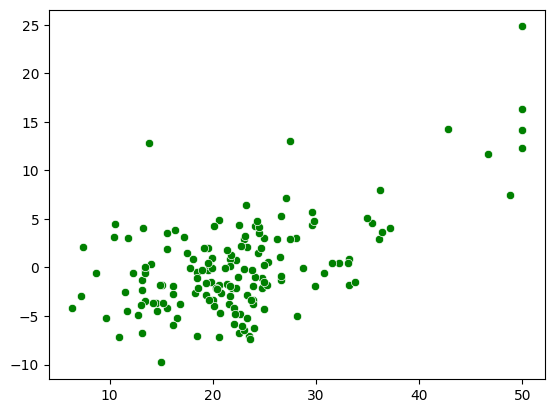

In [17]:
#create a residual plot
sns.scatterplot(x=pred.predictions.select('medv').rdd.map(lambda x: x['medv']).collect(), y=residual, color='green')

In [18]:
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Step 1: Calculate residuals and add them as a new column
pred_with_residuals = pred.predictions.withColumn('residual', F.col('medv') - F.col('prediction'))

# Step 2: Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='assembled_features')
assembled = assembler.transform(pred_with_residuals)

# Step 3: Select the assembled features and residuals
train_data_with_residuals = assembled.select('assembled_features', 'residual')

# Step 4: Fit a linear regression model for residual
linear_reg_resid = LinearRegression(featuresCol='assembled_features', labelCol='residual')
model_resid = linear_reg_resid.fit(train_data_with_residuals)

# Display the model summary
residual_summary = model_resid.summary
residual_summary.predictions.show()



+--------------------+-------------------+--------------------+
|  assembled_features|           residual|          prediction|
+--------------------+-------------------+--------------------+
|[0.00632,18.0,2.3...| -6.223688917850634| -0.7669138246591807|
|[0.00906,90.0,2.9...|0.49929359456476874| -0.9378427138268748|
|[0.01311,90.0,1.2...|  4.583542881522931| 0.49616482849778265|
|[0.02498,0.0,1.89...| -5.188006600462877|  0.9362654143153257|
|[0.02731,0.0,7.07...|-3.7155150326814166| -1.1315282775984699|
|[0.02763,75.0,2.9...| -0.617015311788645| -0.5001716624858581|
|[0.02875,28.0,15....| -4.284734688991591| -0.8960571382812716|
|[0.02899,40.0,1.2...|  5.261213723911741|   2.207383578946608|
|[0.03041,0.0,5.19...|-0.4763331322755029|  0.8076316964879204|
|[0.03113,0.0,4.39...| 1.4656413684798544|  1.2639576365579401|
|[0.0315,95.0,1.47...|  5.067016508235852| 0.32090316169598765|
|[0.03427,0.0,5.19...|-0.2670664043855915|   1.104727018345752|
|[0.03584,80.0,3.3...|  -7.0384489224823

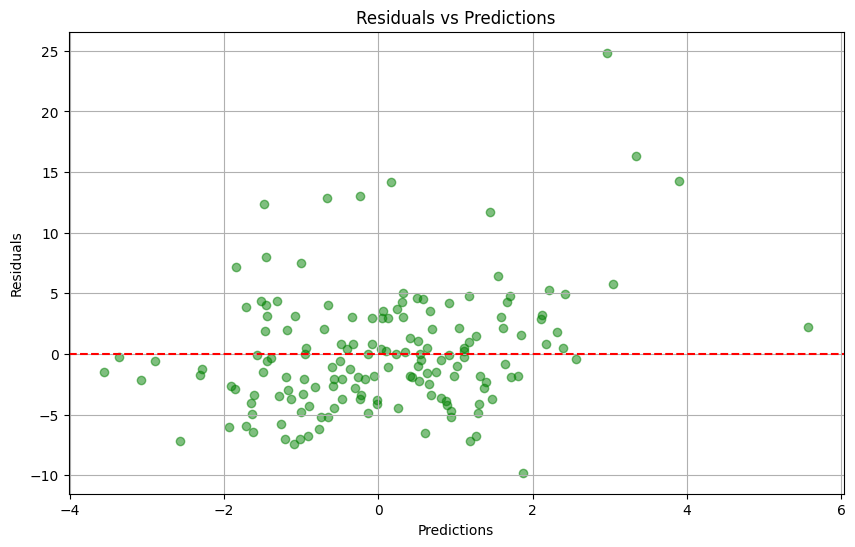

In [25]:
!pip install pandas
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
df = residual_summary.predictions.toPandas()

# Plotting the residuals vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(df['prediction'], df['residual'], alpha=0.5, color='Green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [23]:
!pip install pandas
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F

# Assuming 'pred' is the variable holding your predictions from a previous step
predictions = pred.predictions  # Assign the predictions DataFrame to 'predictions'

# Calculate squared residuals and add them as a new column
predictions = predictions.withColumn('squared_residuals', F.pow(F.col('medv') - F.col('prediction'), 2))

# Define the auxiliary regression model
aux_lr = LinearRegression(featuresCol="features", labelCol="squared_residuals", predictionCol="aux_prediction")

# Fit the model
aux_lr_model = aux_lr.fit(predictions)  # Now 'predictions' contains the 'squared_residuals' column

In [24]:
# Perform the Test
# Number of observations
n = predictions.count()

# R-squared of the auxiliary regression
r_squared = aux_lr_model.summary.r2

# Breusch-Pagan test statistic
bp_statistic = n * r_squared

# p-value for the test statistic
from scipy.stats import chi2

p_value = chi2.sf(bp_statistic, df=aux_lr_model.numFeatures)

print(f"Breusch-Pagan Test Statistic: {bp_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Heteroscedasticity is present.")
else:
    print("Fail to reject the null hypothesis: No evidence of heteroscedasticity.")

Breusch-Pagan Test Statistic: 37.1590973479183
p-value: 0.0003911670729125313
Reject the null hypothesis: Heteroscedasticity is present.
